# LSTM模型优化

In [1]:
# 都有的包，直接导入
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Activation, LSTM, GRU, Dropout, Attention, AdditiveAttention, Layer, Input, RepeatVector
from tensorflow.python.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, r2_score,make_scorer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# 超参数配置
param_grid = {
    'units': [10, 50, 100, 150],
    'activation': ['sigmoid', 'relu', 'tanh', 'softmax'],
    'optimizer': ['sgd', 'adagrad', 'adam', 'adamax'],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'attention': ['additive', 'attention', 'soft', 'time']
}
time_step = 2

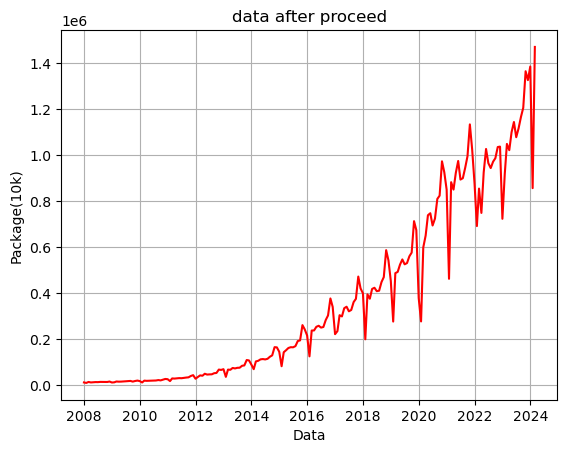

In [3]:
# 图形绘制函数
def all_data(data, title=''):
    plt.plot(data['Date'],data['Pack(10k)'], color='r')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Package(10k)')
    plt.grid(True)
    plt.show()
# 处理后数据导入与展示
index = pd.read_csv('D:\Codes\Python\pythonProject\\test/multi_models/pack_data.csv')
data = index
data['Date']=pd.to_datetime(data['Date'],format='%Y-%m ')   #格式转化

all_data(data, title='data after proceed')    # 数据展示

# 模型开始构建

In [4]:
#划分训练集和测试集
# 数据初步分组
data = np.array(data)
data_train = data[:144] #训练集,2008年-2019年的数据，共144个
data_train_time = data_train[:,0]   #训练数据时间标签
data_train_pack = data_train[:,1]   #训练数据
data_test = data[144:192]  #测试集,仅有2021年-2023年的数据，共36个
data_test_time = data_test[:,0] #测试数据时间标签
data_test_pack = data_test[:,1] #测试数据
#归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_pack = scaler.fit_transform(data_train_pack.reshape(-1,1))
data_test_pack = scaler.transform(data_test_pack.reshape(-1,1))
# 分离特征和目标
train_x, test_x = data_train_pack[:,0], data_test_pack[:,0]
time_y = data_test_time[time_step:]
time_x = data_test_time[:-time_step]
# 数据重塑 创建指定时间步长的数据集
def create_dataset(x, time_step):
    xs, ys = [], []
    for i in range(len(x) - time_step):
        v = x[i:(i + time_step)]
        xs.append(v)
        ys.append(x[i + time_step])
    return np.array(xs), np.array(ys)

In [5]:
# 数据重塑，输入RNN模型的数据中需要两个维度{[样本数量],[时间步长],[特征数量]}
train_x, test_x = data_train_pack[:,0], data_test_pack[:,0]
time_y = data_test_time[time_step:]
time_x = data_test_time[:-time_step]
train_x, train_y = create_dataset(train_x, time_step)
test_x, test_y = create_dataset(test_x, time_step)
train_x = train_x.reshape(train_x.shape[0], time_step, 1)
test_x = test_x.reshape(test_x.shape[0], time_step, 1)

In [6]:
# 自定义Attention机制
# 自定义软注意力层
class SoftAttention(Layer):
    def __init__(self, **kwargs):
        super(SoftAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='glorot_uniform')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros')
        super(SoftAttention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        return K.sum(output, axis=1)
# 自定义时间注意力层
class TimeAttention(Layer):
    def __init__(self, time_step,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = time_step
        self.features_dim = 0
        super(TimeAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'step_dim': self.step_dim,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
        })
        return config

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())

        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [ ]:
# 模型构建(整体测试）
def get_model(units, activation, optimizer, dropout, time_step, attention):

    input_layer = Input(shape=(time_step,1))
    lstm_out = LSTM(units=units, return_sequences=True, activation=activation)(input_layer)
    dropout_out = Dropout(dropout)(lstm_out)
    lstm_out_2 = LSTM(units=units, return_sequences=True, activation=activation)(dropout_out)
# 对注意力层的选择-----
    if attention == 'soft':
        attention_out = SoftAttention()(lstm_out_2)
    elif attention == 'time':
        attention_out = TimeAttention(time_step)(lstm_out_2)
    elif attention == 'additive':
        attention_out = AdditiveAttention()([lstm_out_2, lstm_out_2])
    elif attention == 'attention':
        attention_out = Attention()([lstm_out_2, lstm_out_2])
    else:
        print('No such attention method!')
        return
# ------------------
    output_layer = Dense(units=1)(attention_out)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
model = get_model(units=param_grid['units'][0], activation=param_grid['activation'][0]
                  , optimizer=param_grid['optimizer'][0], dropout=param_grid['dropout'][0], time_step=time_step, attention=param_grid['attention'][0])

In [ ]:
history = model.fit(train_x, train_y, batch_size=12, epochs=10, verbose=2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# 结构改进

In [118]:
# 模型构建(结构改进）
def structed_model(dropout, attention):
    # 其余参数在这里定义好
    units = 10
    activation = 'relu'
    # optimizer = optimizers.adagrad_v2.Adagrad(learning_rate=0.1)
    optimizer = 'adam'
# 根据注意力机制的不同选择不同的模型构建
    # 软注意力
    if attention == 'soft':
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, activation=activation, input_shape=(time_step,1)))
        model.add(Dropout(dropout))
        model.add(SoftAttention())
        model.add(RepeatVector(1))  # 增长一个维度
        model.add(LSTM(units=units, return_sequences=True, activation=activation))
        model.add(Dense(units=1))
    # 时间注意力
    elif attention == 'time':
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, activation=activation, input_shape=(time_step,1)))
        model.add(Dropout(dropout))
        model.add(TimeAttention(time_step))
        model.add(RepeatVector(1))
        model.add(LSTM(units=units, return_sequences=True, activation=activation))
        model.add(Dense(units=1))
    # 加性注意力
    elif attention == 'additive':
        input_layer = Input(shape=(time_step,1))
        lstm_out = LSTM(units=units, return_sequences=True, activation=activation)(input_layer)
        dropout_out = Dropout(dropout)(lstm_out)
        attention_out = AdditiveAttention()([dropout_out, dropout_out])
        lstm_out_2 = LSTM(units=units, activation=activation)(attention_out)
        output_layer = Dense(units=1)(lstm_out_2)
        model = Model(inputs=input_layer, outputs=output_layer)
    # Keras自带的注意力
    elif attention == 'attention':
        input_layer = Input(shape=(time_step,1))
        lstm_out = LSTM(units=units, return_sequences=True, activation=activation)(input_layer)
        dropout_out = Dropout(dropout)(lstm_out)
        attention_out = Attention()([dropout_out, dropout_out])
        lstm_out_2 = LSTM(units=units, activation=activation)(attention_out)
        output_layer = Dense(units=1)(lstm_out_2)
        model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    return model

In [89]:
models = []
for i in range(4):
    model = structed_model(dropout=0.2, attention=param_grid['attention'][i])
    model.fit(train_x, train_y, batch_size=6, epochs=30, verbose=2)
    models.append(model)

Epoch 1/30
24/24 - 7s - loss: 0.1858
Epoch 2/30
24/24 - 0s - loss: 0.0673
Epoch 3/30
24/24 - 0s - loss: 0.0642
Epoch 4/30
24/24 - 0s - loss: 0.0653
Epoch 5/30
24/24 - 0s - loss: 0.0663
Epoch 6/30
24/24 - 0s - loss: 0.0639
Epoch 7/30
24/24 - 0s - loss: 0.0629
Epoch 8/30
24/24 - 0s - loss: 0.0638
Epoch 9/30
24/24 - 0s - loss: 0.0626
Epoch 10/30
24/24 - 0s - loss: 0.0632
Epoch 11/30
24/24 - 0s - loss: 0.0597
Epoch 12/30
24/24 - 0s - loss: 0.0615
Epoch 13/30
24/24 - 0s - loss: 0.0636
Epoch 14/30
24/24 - 0s - loss: 0.0590
Epoch 15/30
24/24 - 0s - loss: 0.0585
Epoch 16/30
24/24 - 0s - loss: 0.0641
Epoch 17/30
24/24 - 0s - loss: 0.0605
Epoch 18/30
24/24 - 0s - loss: 0.0569
Epoch 19/30
24/24 - 0s - loss: 0.0562
Epoch 20/30
24/24 - 0s - loss: 0.0573
Epoch 21/30
24/24 - 0s - loss: 0.0549
Epoch 22/30
24/24 - 0s - loss: 0.0528
Epoch 23/30
24/24 - 0s - loss: 0.0490
Epoch 24/30
24/24 - 0s - loss: 0.0483
Epoch 25/30
24/24 - 0s - loss: 0.0478
Epoch 26/30
24/24 - 0s - loss: 0.0447
Epoch 27/30
24/24 - 0

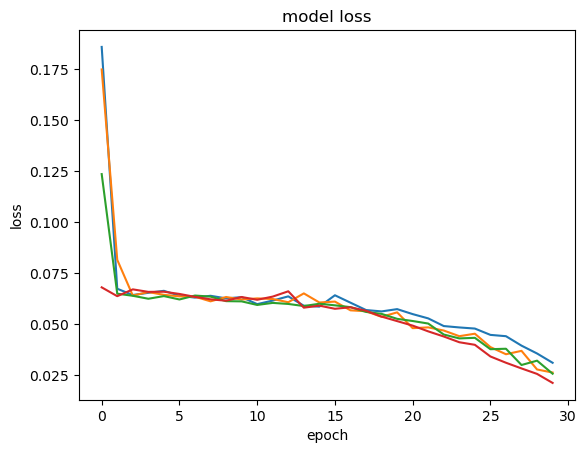

In [90]:
for i in range(4):
    plt.plot(models[i].history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [91]:
preds = []
for i in range(4):
    pred = models[i].predict(test_x)
    pred = scaler.inverse_transform(pred.reshape(-1,1))
    preds.append(pred)

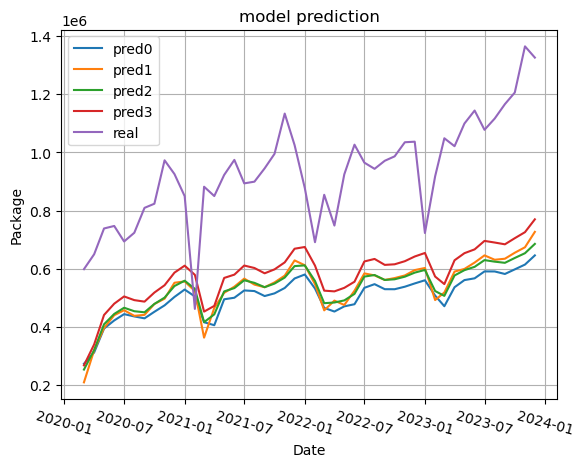

In [96]:
get_prediction_plt(preds, real_y)

In [123]:
# 使用网格搜索找到最优Dropout与Attention方法
model = KerasRegressor(build_fn=structed_model, epochs=30, batch_size=12, verbose=2)

C:\Users\31969\AppData\Local\Temp\ipykernel_13716\760287495.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=structed_model, epochs=30, batch_size=12, verbose=2)


In [124]:
structure_para =  {key: param_grid[key] for key in ['attention', 'dropout']}

In [125]:
''' 参数详解
estimator参数指定了需要进行调优的模型（即model），param_grid参数指定了需要搜索的超参数范围，n_jobs参数指定了并行计算的线程数，设置为-1表示使用所有可用的CPU核心，cv参数指定了交叉验证的折数为3，verbose参数同样控制输出信息的详细程度，设置为2表示输出调优过程的详细信息。通过grid_search函数，可以自动搜索最优的超参数组合，并训练出对应的最优模型。scoring为添加评分函数，此处使用r2_score函数。
'''
# grid_search = GridSearchCV(estimator=model, param_grid=structure_para, n_jobs=-1, cv=3, verbose=1, scoring=get_r2_score)
# 创建GridSearchCV对象
grid_search = GridSearchCV(
    estimator=model,
    param_grid=structure_para,  # 使用的参数集合
    cv=3,  # 交叉验证的折数
    return_train_score=True,  # 是否返回训练分数
    n_jobs=-1,  # 使用所有CPU核心
    verbose=2  # 输出详细信息
)

In [126]:
grid_search.fit(train_x, train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30
12/12 - 5s - loss: 0.1128
Epoch 2/30
12/12 - 0s - loss: 0.1015
Epoch 3/30
12/12 - 0s - loss: 0.0903
Epoch 4/30
12/12 - 0s - loss: 0.0820
Epoch 5/30
12/12 - 0s - loss: 0.0721
Epoch 6/30
12/12 - 0s - loss: 0.0656
Epoch 7/30
12/12 - 0s - loss: 0.0573
Epoch 8/30
12/12 - 0s - loss: 0.0526
Epoch 9/30
12/12 - 0s - loss: 0.0458
Epoch 10/30
12/12 - 0s - loss: 0.0452
Epoch 11/30
12/12 - 0s - loss: 0.0403
Epoch 12/30
12/12 - 0s - loss: 0.0369
Epoch 13/30
12/12 - 0s - loss: 0.0360
Epoch 14/30
12/12 - 0s - loss: 0.0323
Epoch 15/30
12/12 - 0s - loss: 0.0278
Epoch 16/30
12/12 - 0s - loss: 0.0268
Epoch 17/30
12/12 - 0s - loss: 0.0231
Epoch 18/30
12/12 - 0s - loss: 0.0246
Epoch 19/30
12/12 - 0s - loss: 0.0194
Epoch 20/30
12/12 - 0s - loss: 0.0217
Epoch 21/30
12/12 - 0s - loss: 0.0192
Epoch 22/30
12/12 - 0s - loss: 0.0157
Epoch 23/30
12/12 - 0s - loss: 0.0134
Epoch 24/30
12/12 - 0s - loss: 0.0171
Epoch 25/30
12/12 - 0s - loss: 0.017

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000206073C6590>,
             n_jobs=-1,
             param_grid={'attention': ['additive', 'attention', 'soft', 'time'],
                         'dropout': [0.2, 0.3, 0.4, 0.5]},
             return_train_score=True, verbose=2)

In [127]:
struct_opt_table = pd.DataFrame(grid_search.cv_results_)
# 选择指定列
selected_col = ['param_attention', 'param_dropout', 'mean_train_score', 'mean_test_score', 'rank_test_score']
struct_opt = struct_opt_table[selected_col]
# 只要排名前五
struct_opt = struct_opt.sort_values(by='rank_test_score')
struct_opt = struct_opt.head(5)

In [129]:
struct_opt.to_csv('./better_lstm/struct_opt_top_5.csv')

In [98]:
# 排名前三的参数
struct_para_attention = ['additive', 'attention', 'time']
struct_para_dropout = [0.5, 0.2, 0.3]

In [119]:
struct_opt_models = []
for i in range(len(struct_para_attention)):
    model = structed_model(dropout=struct_para_dropout[i], attention=struct_para_attention[i])
    model.fit(train_x, train_y, batch_size=12, epochs=30, verbose=2)
    struct_opt_models.append(model)

Epoch 1/30
12/12 - 5s - loss: 0.1115
Epoch 2/30
12/12 - 0s - loss: 0.1018
Epoch 3/30
12/12 - 0s - loss: 0.0932
Epoch 4/30
12/12 - 0s - loss: 0.0852
Epoch 5/30
12/12 - 0s - loss: 0.0771
Epoch 6/30
12/12 - 0s - loss: 0.0697
Epoch 7/30
12/12 - 0s - loss: 0.0627
Epoch 8/30
12/12 - 0s - loss: 0.0580
Epoch 9/30
12/12 - 0s - loss: 0.0556
Epoch 10/30
12/12 - 0s - loss: 0.0497
Epoch 11/30
12/12 - 0s - loss: 0.0474
Epoch 12/30
12/12 - 0s - loss: 0.0429
Epoch 13/30
12/12 - 0s - loss: 0.0362
Epoch 14/30
12/12 - 0s - loss: 0.0351
Epoch 15/30
12/12 - 0s - loss: 0.0308
Epoch 16/30
12/12 - 0s - loss: 0.0282
Epoch 17/30
12/12 - 0s - loss: 0.0310
Epoch 18/30
12/12 - 0s - loss: 0.0247
Epoch 19/30
12/12 - 0s - loss: 0.0220
Epoch 20/30
12/12 - 0s - loss: 0.0232
Epoch 21/30
12/12 - 0s - loss: 0.0218
Epoch 22/30
12/12 - 0s - loss: 0.0236
Epoch 23/30
12/12 - 0s - loss: 0.0199
Epoch 24/30
12/12 - 0s - loss: 0.0198
Epoch 25/30
12/12 - 0s - loss: 0.0204
Epoch 26/30
12/12 - 0s - loss: 0.0188
Epoch 27/30
12/12 - 0

In [108]:
def get_loss_plt(models):
    for i in range(len(models)):
        plt.plot(models[i].history.history['loss'],
                 label='attention='+str(struct_para_attention[i])+',dropout='+str(struct_para_dropout[i]))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

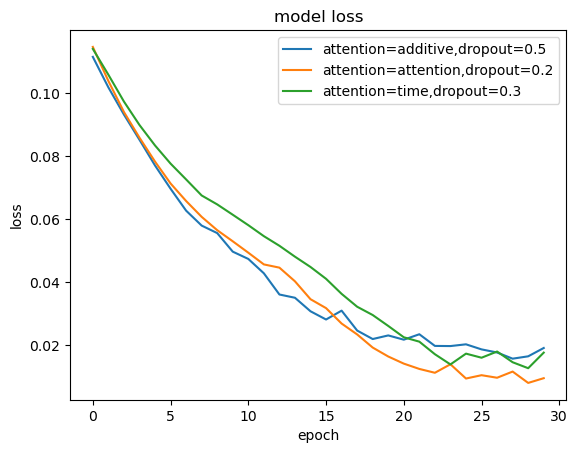

In [120]:
get_loss_plt(struct_opt_models)

In [101]:
def get_prediction_plt(preds, real_y):
    for i in range(len(preds)):
        plt.plot(time_y, preds[i],  label='attention='+str(struct_para_attention[i])+',dropout='+str(struct_para_dropout[i]))
        # plt.plot(time_y, preds[i], label = 'pred'+str(i))
    plt.plot(time_y, real_y, label='real')
    plt.title('model prediction')
    plt.ylabel('Package')
    plt.xlabel('Date')
    plt.legend()
    plt.xticks(rotation=-15)
    plt.grid()
    plt.show()


In [0]:
# 模型预测
def get_prediction(models, test_x):
    preds = []
    for i in range(len(models)):
        pred = models[i].predict(test_x)
        preds.append(scaler.inverse_transform(pred.reshape(-1,1)))
    return preds

In [121]:
struct_opt_preds = get_prediction(struct_opt_models, test_x)

In [102]:
real_y = scaler.inverse_transform(test_y.reshape(-1,1))
real_x = scaler.inverse_transform(test_x[:,0].reshape(-1,1))

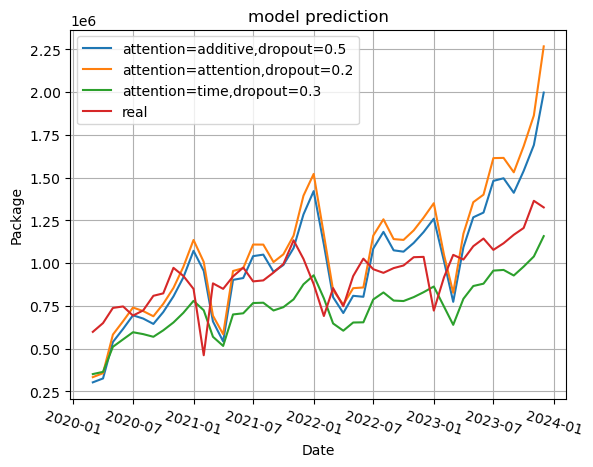

In [133]:
get_prediction_plt(struct_opt_preds, real_y)

In [131]:
# 模型误差评估
def get_error(real_y, y_pred):
    mse = np.mean((real_y - y_pred) ** 2)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(mean_squared_log_error(real_y, y_pred))
    mape = np.mean(np.abs((real_y - y_pred) / real_y)) * 100
    r2 = r2_score(real_y, y_pred)
    errs = [mse, rmse, rmsle, mape, r2]
    return errs

In [132]:
# 获取评估结果
errs = []
for i in range(len(struct_opt_preds)):
    err = get_error(real_x, struct_opt_preds[i])
    errs.append(err)
errs = pd.DataFrame(errs, columns=['mse', 'rmse', 'rmsle', 'mape', 'r2'], index=['attention='+str(struct_para_attention[i])+',dropout='+str(struct_para_dropout[i]) for i in range(len(struct_opt_preds))])
mean = errs.mean(axis=0)
mean = pd.DataFrame(mean).T
mean.index = ['Average']
errs = pd.concat([errs, mean], axis=0)

In [134]:
errs.to_csv('./better_lstm/struct_opt_errs.csv')

In [135]:
# 重复测试
dropout = 0.3
attention = 'time'
time_att_models = []
for i in range(10):
    model = structed_model(dropout=dropout, attention=attention)
    model.fit(train_x, train_y, batch_size=12, epochs=30, verbose=2)
    time_att_models.append(model)


Epoch 1/30
12/12 - 5s - loss: 0.1119
Epoch 2/30
12/12 - 0s - loss: 0.1043
Epoch 3/30
12/12 - 0s - loss: 0.0970
Epoch 4/30
12/12 - 0s - loss: 0.0905
Epoch 5/30
12/12 - 0s - loss: 0.0839
Epoch 6/30
12/12 - 0s - loss: 0.0774
Epoch 7/30
12/12 - 0s - loss: 0.0715
Epoch 8/30
12/12 - 0s - loss: 0.0669
Epoch 9/30
12/12 - 0s - loss: 0.0605
Epoch 10/30
12/12 - 0s - loss: 0.0566
Epoch 11/30
12/12 - 0s - loss: 0.0517
Epoch 12/30
12/12 - 0s - loss: 0.0456
Epoch 13/30
12/12 - 0s - loss: 0.0415
Epoch 14/30
12/12 - 0s - loss: 0.0382
Epoch 15/30
12/12 - 0s - loss: 0.0346
Epoch 16/30
12/12 - 0s - loss: 0.0302
Epoch 17/30
12/12 - 0s - loss: 0.0254
Epoch 18/30
12/12 - 0s - loss: 0.0197
Epoch 19/30
12/12 - 0s - loss: 0.0193
Epoch 20/30
12/12 - 0s - loss: 0.0177
Epoch 21/30
12/12 - 0s - loss: 0.0179
Epoch 22/30
12/12 - 0s - loss: 0.0154
Epoch 23/30
12/12 - 0s - loss: 0.0162
Epoch 24/30
12/12 - 0s - loss: 0.0116
Epoch 25/30
12/12 - 0s - loss: 0.0128
Epoch 26/30
12/12 - 0s - loss: 0.0146
Epoch 27/30
12/12 - 0

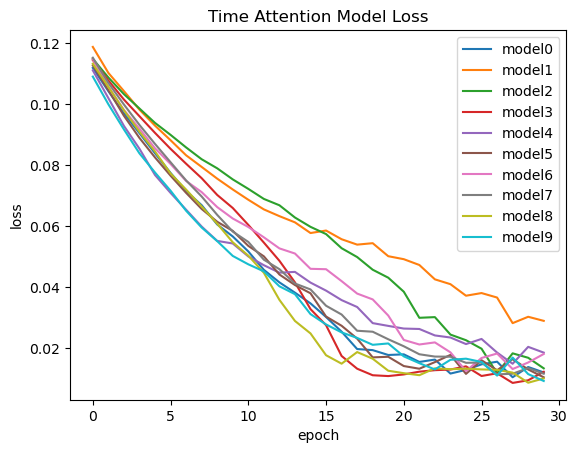

In [138]:
for i in range(len(time_att_models)):
    plt.plot(time_att_models[i].history.history['loss'],
             label='model'+str(i))
plt.title('Time Attention Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [139]:
time_att_preds = get_prediction(time_att_models, test_x)

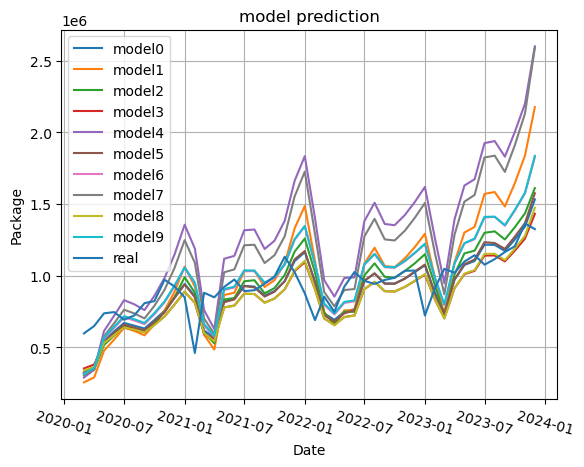

In [140]:
# 模型预测结果图
for i in range(len(time_att_preds)):
    plt.plot(time_y, time_att_preds[i],  label='model'+str(i))
plt.plot(time_y, real_y, label='real')
plt.title('model prediction')
plt.ylabel('Package')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=-15)
plt.grid()
plt.show()

In [141]:
time_att_errs = []
for i in range(len(time_att_preds)):
    err = get_error(real_x, time_att_preds[i])
    time_att_errs.append(err)
time_att_errs = pd.DataFrame(time_att_errs, columns=['mse', 'rmse', 'rmsle', 'mape', 'r2'], index=['model'+str(i) for i in range(len(time_att_preds))])
mean = time_att_errs.mean(axis=0)
mean = pd.DataFrame(mean).T
mean.index = ['Average']
time_att_errs = pd.concat([time_att_errs, mean], axis=0)

In [142]:
time_att_errs.to_csv('./better_lstm/time_att_errs.csv')

# 参数改进

In [144]:
# 参数获取
param_opt_grid = {key: param_grid[key] for key in ['units', 'activation', 'optimizer']}

In [146]:
# 模型构建（直接用时间注意力机制）
def prar_opt_model(units, activation, optimizer):
    dropout = 0.3
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, activation=activation, input_shape=(time_step,1)))
    model.add(Dropout(dropout))
    model.add(TimeAttention(time_step))
    model.add(RepeatVector(1))
    model.add(LSTM(units=units, return_sequences=True, activation=activation))
    model.add(Dense(units=1))
    model.compile(loss='mse', optimizer=optimizer)
    return model

Epoch 1/30
12/12 - 5s - loss: 0.1172
Epoch 2/30
12/12 - 0s - loss: 0.1055
Epoch 3/30
12/12 - 0s - loss: 0.0953
Epoch 4/30
12/12 - 0s - loss: 0.0862
Epoch 5/30
12/12 - 0s - loss: 0.0791
Epoch 6/30
12/12 - 0s - loss: 0.0721
Epoch 7/30
12/12 - 0s - loss: 0.0661
Epoch 8/30
12/12 - 0s - loss: 0.0609
Epoch 9/30
12/12 - 0s - loss: 0.0580
Epoch 10/30
12/12 - 0s - loss: 0.0523
Epoch 11/30
12/12 - 0s - loss: 0.0508
Epoch 12/30
12/12 - 0s - loss: 0.0474
Epoch 13/30
12/12 - 0s - loss: 0.0442
Epoch 14/30
12/12 - 0s - loss: 0.0404
Epoch 15/30
12/12 - 0s - loss: 0.0356
Epoch 16/30
12/12 - 0s - loss: 0.0334
Epoch 17/30
12/12 - 0s - loss: 0.0284
Epoch 18/30
12/12 - 0s - loss: 0.0216
Epoch 19/30
12/12 - 0s - loss: 0.0187
Epoch 20/30
12/12 - 0s - loss: 0.0142
Epoch 21/30
12/12 - 0s - loss: 0.0132
Epoch 22/30
12/12 - 0s - loss: 0.0124
Epoch 23/30
12/12 - 0s - loss: 0.0097
Epoch 24/30
12/12 - 0s - loss: 0.0094
Epoch 25/30
12/12 - 0s - loss: 0.0103
Epoch 26/30
12/12 - 0s - loss: 0.0119
Epoch 27/30
12/12 - 0

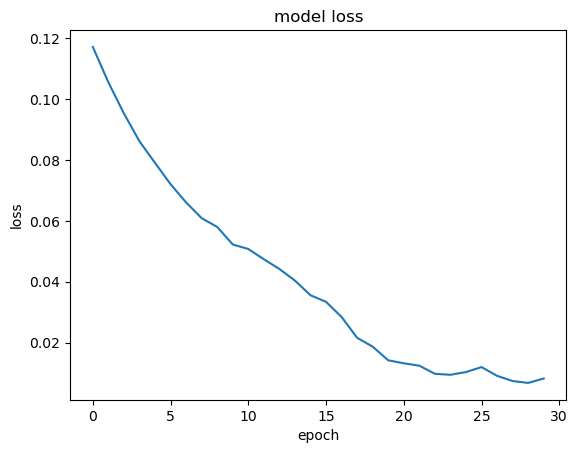

In [166]:
# 单组模型生成调试
model = prar_opt_model(units=10, activation='tanh', optimizer='adam')
model.fit(train_x, train_y, batch_size=12, epochs=30, verbose=2)
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [161]:
search_model = KerasRegressor(build_fn=prar_opt_model, epochs=30, batch_size=12, verbose=2)

random_search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=param_opt_grid,  # 使用的参数集合
    n_iter=24,  # 随机搜索的次数
    cv=3,  # 交叉验证的折数
    random_state=2,  # 随机数种子
    return_train_score=True,  # 是否返回训练分数
    n_jobs=-1,  # 使用所有CPU核心
)
random_search.fit(train_x, train_y)

C:\Users\31969\AppData\Local\Temp\ipykernel_13716\1761351175.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  search_model = KerasRegressor(build_fn=prar_opt_model, epochs=30, batch_size=12, verbose=2)


Epoch 1/30
12/12 - 17s - loss: 0.1021
Epoch 2/30
12/12 - 1s - loss: 0.0738
Epoch 3/30
12/12 - 1s - loss: 0.0533
Epoch 4/30
12/12 - 1s - loss: 0.0362
Epoch 5/30
12/12 - 1s - loss: 0.0302
Epoch 6/30
12/12 - 1s - loss: 0.0256
Epoch 7/30
12/12 - 0s - loss: 0.0215
Epoch 8/30
12/12 - 1s - loss: 0.0179
Epoch 9/30
12/12 - 0s - loss: 0.0140
Epoch 10/30
12/12 - 0s - loss: 0.0101
Epoch 11/30
12/12 - 0s - loss: 0.0082
Epoch 12/30
12/12 - 0s - loss: 0.0067
Epoch 13/30
12/12 - 1s - loss: 0.0057
Epoch 14/30
12/12 - 1s - loss: 0.0055
Epoch 15/30
12/12 - 1s - loss: 0.0061
Epoch 16/30
12/12 - 1s - loss: 0.0050
Epoch 17/30
12/12 - 0s - loss: 0.0057
Epoch 18/30
12/12 - 0s - loss: 0.0057
Epoch 19/30
12/12 - 0s - loss: 0.0056
Epoch 20/30
12/12 - 0s - loss: 0.0051
Epoch 21/30
12/12 - 0s - loss: 0.0050
Epoch 22/30
12/12 - 0s - loss: 0.0057
Epoch 23/30
12/12 - 0s - loss: 0.0057
Epoch 24/30
12/12 - 0s - loss: 0.0053
Epoch 25/30
12/12 - 0s - loss: 0.0055
Epoch 26/30
12/12 - 0s - loss: 0.0064
Epoch 27/30
12/12 - 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002064DED3990>,
                   n_iter=24, n_jobs=-1,
                   param_distributions={'activation': ['sigmoid', 'relu',
                                                       'tanh', 'softmax'],
                                        'optimizer': ['sgd', 'adagrad', 'adam',
                                                      'adamax'],
                                        'units': [10, 50, 100, 150]},
                   random_state=2, return_train_score=True)

In [ ]:
best_params = []


In [162]:
param_opt_table = pd.DataFrame(random_search.cv_results_)[['param_units', 'param_activation', 'param_optimizer', 'mean_train_score', 'mean_test_score', 'rank_test_score']]
param_opt_table = param_opt_table.sort_values(by='rank_test_score')
best_params.append(param_opt_table.head(2))

In [163]:
best_params = pd.concat(best_params, axis=0)

In [164]:
best_params.to_csv('./better_lstm/best_params.csv')

In [167]:
# 收集初始参数
units = [50, 150, 100]
activation = ['relu', 'relu', 'tanh']
optimizer = ['adam', 'adam', 'adamax']
params_opt_models = []
for i in range(len(units)):
    model = prar_opt_model(units[i], activation[i], optimizer[i])
    model.fit(train_x, train_y, batch_size=12, epochs=30, verbose=2)
    params_opt_models.append(model)

Epoch 1/30
12/12 - 6s - loss: 0.1110
Epoch 2/30
12/12 - 0s - loss: 0.0982
Epoch 3/30
12/12 - 0s - loss: 0.0846
Epoch 4/30
12/12 - 0s - loss: 0.0706
Epoch 5/30
12/12 - 0s - loss: 0.0554
Epoch 6/30
12/12 - 0s - loss: 0.0445
Epoch 7/30
12/12 - 0s - loss: 0.0375
Epoch 8/30
12/12 - 0s - loss: 0.0286
Epoch 9/30
12/12 - 0s - loss: 0.0216
Epoch 10/30
12/12 - 0s - loss: 0.0139
Epoch 11/30
12/12 - 0s - loss: 0.0107
Epoch 12/30
12/12 - 0s - loss: 0.0076
Epoch 13/30
12/12 - 0s - loss: 0.0090
Epoch 14/30
12/12 - 0s - loss: 0.0071
Epoch 15/30
12/12 - 0s - loss: 0.0071
Epoch 16/30
12/12 - 0s - loss: 0.0065
Epoch 17/30
12/12 - 0s - loss: 0.0068
Epoch 18/30
12/12 - 0s - loss: 0.0069
Epoch 19/30
12/12 - 0s - loss: 0.0069
Epoch 20/30
12/12 - 0s - loss: 0.0068
Epoch 21/30
12/12 - 0s - loss: 0.0067
Epoch 22/30
12/12 - 0s - loss: 0.0068
Epoch 23/30
12/12 - 0s - loss: 0.0088
Epoch 24/30
12/12 - 0s - loss: 0.0058
Epoch 25/30
12/12 - 0s - loss: 0.0064
Epoch 26/30
12/12 - 0s - loss: 0.0059
Epoch 27/30
12/12 - 0

In [172]:
def get_loss_plt(models):
    for i in range(len(models)):
        plt.plot(models[i].history.history['loss'],
                 label='units='+str(units[i])+', act='+str(activation[i])+', opt='+str(optimizer[i]))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

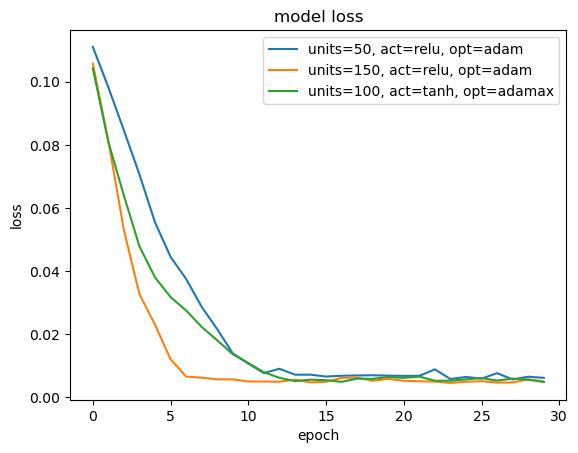

In [173]:
get_loss_plt(params_opt_models)

In [177]:
# 获取预测结果
params_opt_preds = get_prediction(params_opt_models, test_x)

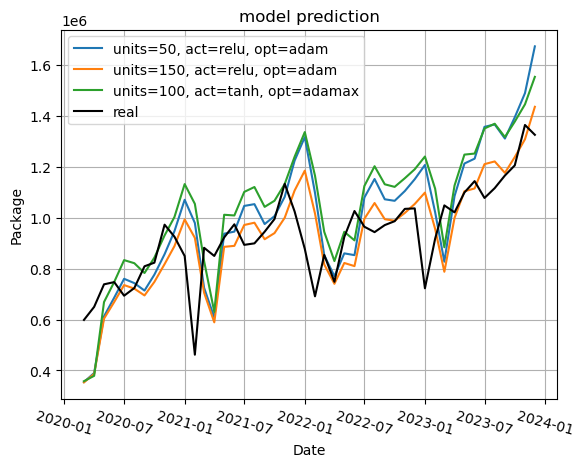

In [182]:
# 模型预测结果图
for i in range(len(params_opt_models)):
    plt.plot(time_y,params_opt_preds[i],  label='units='+str(units[i])+', act='+str(activation[i])+', opt='+str(optimizer[i]))
plt.plot(time_y, real_y, label='real', color='k')
plt.title('model prediction')
plt.ylabel('Package')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=-15)
plt.grid()
plt.show()

In [0]:
# 获取评估结果
errs = []
for i in range(len(params_opt_preds)):
    err = get_error(real_x, params_opt_preds[i])
    errs.append(err)
errs = pd.DataFrame(errs, columns=['mse', 'rmse', 'rmsle', 'mape', 'r2'], index=['units='+str(units[i])+', act='+str(activation[i])+', opt='+str(optimizer[i]) for i in range(len(params_opt_preds))])

In [183]:
errs.to_csv('./better_lstm/params_opt_errs.csv')

In [184]:
best_lstm_models = []
for i in range(10):
    model = prar_opt_model(units=150, activation='relu', optimizer='adam')
    model.fit(train_x, train_y, batch_size=12, epochs=30, verbose=2)
    best_lstm_models.append(model)

Epoch 1/30
12/12 - 6s - loss: 0.1089
Epoch 2/30
12/12 - 0s - loss: 0.0864
Epoch 3/30
12/12 - 0s - loss: 0.0580
Epoch 4/30
12/12 - 0s - loss: 0.0383
Epoch 5/30
12/12 - 0s - loss: 0.0283
Epoch 6/30
12/12 - 0s - loss: 0.0143
Epoch 7/30
12/12 - 0s - loss: 0.0068
Epoch 8/30
12/12 - 0s - loss: 0.0056
Epoch 9/30
12/12 - 0s - loss: 0.0053
Epoch 10/30
12/12 - 0s - loss: 0.0056
Epoch 11/30
12/12 - 0s - loss: 0.0056
Epoch 12/30
12/12 - 0s - loss: 0.0055
Epoch 13/30
12/12 - 0s - loss: 0.0059
Epoch 14/30
12/12 - 0s - loss: 0.0049
Epoch 15/30
12/12 - 0s - loss: 0.0052
Epoch 16/30
12/12 - 0s - loss: 0.0055
Epoch 17/30
12/12 - 0s - loss: 0.0058
Epoch 18/30
12/12 - 0s - loss: 0.0053
Epoch 19/30
12/12 - 0s - loss: 0.0048
Epoch 20/30
12/12 - 0s - loss: 0.0057
Epoch 21/30
12/12 - 0s - loss: 0.0058
Epoch 22/30
12/12 - 0s - loss: 0.0053
Epoch 23/30
12/12 - 0s - loss: 0.0062
Epoch 24/30
12/12 - 0s - loss: 0.0053
Epoch 25/30
12/12 - 0s - loss: 0.0048
Epoch 26/30
12/12 - 0s - loss: 0.0045
Epoch 27/30
12/12 - 0

In [0]:
best_lstm_preds = get_prediction(best_lstm_models, test_x)
best_lstm_errs = []
for i in range(len(best_lstm_models)):
    err = get_error(real_x, best_lstm_preds[i])
    best_lstm_errs.append(err)

In [186]:
best_lstm_errs = pd.DataFrame(best_lstm_errs, columns=['mse', 'rmse', 'rmsle', 'mape', 'r2'], index=['model'+str(i) for i in range(len(best_lstm_models))])
mean = best_lstm_errs.mean(axis=0)
mean = pd.DataFrame(mean).T
mean.index = ['Average']
best_lstm_errs = pd.concat([best_lstm_errs, mean], axis=0)

In [187]:
best_lstm_errs.to_csv('./better_lstm/best_lstm_errs.csv')